<b><font color='darkred'>
SVM - Support Vector Machine
-----------------
➔ Verwenden statistischer Größen der Zeitreihen als Features


In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection, svm, preprocessing
from sklearn.decomposition import PCA
import joblib
import helper

In [ ]:
# PCA Anwendung?
pca = False      
n_components = 0.98

# Neue zusätzliche synthetische Daten erzeugen?
synthetic_data = False 

# Skalierung für Zielvariable Zugfestigkeit
SCALE = 2000

# Statistische Kennzahlen für die Modellerstellung
"""
STATS = [
    # Power (p_*)
    "p_median", "p_std", "p_max", "p_q25", "p_q75", 
    "p_f_ratio", "p_d_ratio", "p_t_ratio",
    #"p_mean", "p_iqr_range", 
    
    # Force (f_*)
    "f_median", "f_std", "f_max", "f_q25", "f_q75", 
    "f_d_ratio", "f_t_ratio",
    #"f_mean", "f_iqr_range", 

    # Distance (d_*)
    "d_median", "d_std", "d_max", "d_q25", "d_q75", 
    "d_t_ratio", #"d_b75",
    #"d_mean",  "d_iqr_range", 

    # Zeitmerkmale
    "t_max",
]
# 'f_iqr_range', 'p_iqr_range', 
 """

# 🏆
STATS = ['p_max', 'p_q75', 'p_median', 'p_f_ratio', 'p_q25', 'p_d_ratio', 'p_t_ratio', 'f_t_ratio', 'f_d_ratio', 't_max', 'p_std', 'd_std']

In [221]:
zugversuche, kurven, versuche_train, versuche_test = helper.read_data()

In [224]:
stat_feat = helper.StatFeatures(STATS)
stat_feat.fit()

StatFeatures(columns=['p_max', 'p_q75', 'p_median', 'p_f_ratio', 'p_q25',
                      'p_d_ratio', 'p_t_ratio', 'f_t_ratio', 'f_d_ratio',
                      't_max', 'p_std', 'd_std'])

In [225]:
X_train = stat_feat.transform(versuche_train.key, kurven)
X_test  = stat_feat.transform(versuche_test.key,  kurven)

print(X_train.shape, X_test.shape) 

(480, 12) (120, 12)


In [226]:
label_train      = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values

label_test      = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values

<b><font color='lightgreen'> Skalierung (Normierung) der Trainings- & Testdaten 

In [227]:
std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled  = std_scaler.transform(X_test)

festigkeit_test  = festigkeit_test/SCALE
festigkeit_train = festigkeit_train/SCALE

# Speichern des Scalers
joblib.dump(std_scaler, "GUI/Maschine1/scaler.joblib")  

['GUI/Maschine1/scaler.joblib']

<b><font color='lightgreen'> Feature Augmentation - Erzeugung zusätzlicher synthetischer Daten - Jittering & Gaussian Noise</b><br>
- neue Trainingsdaten erzeugen und Zielgrößen übernehmen

In [228]:
def add_jitter(X, y_label, y_festigkeit, noise_level=0.05, n_augmentations=3):
    """
    Fügt Jittering (Gaussian Noise) zu den Eingabedaten und der Zugfestigkeit hinzu.

    Parameters:
        X (numpy array): Die ursprünglichen Merkmale.
        y_label (numpy array): Die Klassenzuordnung (Labels).
        y_festigkeit (numpy array): Die Zugfestigkeit.
        noise_level (float): Standardabweichung des Gaussian Noise relativ zur Feature-Standardabweichung.
        n_augmentations (int): Anzahl der neuen synthetischen Datenpunkte pro Originalprobe.

    Returns:
        X_aug (numpy array): Erweitertes Feature-Set mit Jittering.
        y_label_aug (numpy array): Erweitertes Label-Set.
        y_festigkeit_aug (numpy array): Erweitertes Zugfestigkeits-Set.
    """
    X_aug, y_label_aug, y_festigkeit_aug = [], [], []

    for i in range(len(X)):
        for _ in range(n_augmentations):
            # Gaussian Noise für Features
            noise_X = np.random.normal(loc=0, scale=noise_level, size=X.shape[1])
            X_aug.append(X[i] + X[i]*noise_X)

            # Gaussian Noise für Zugfestigkeit (keine Werte kleiner 0 möglich)
            noise_y = np.random.normal(loc=0, scale=noise_level-0.02) #  * np.mean(y_festigkeit))
            new_strength = max(0, y_festigkeit[i] + noise_y)
            y_festigkeit_aug.append(new_strength)

            # Label & Zugfestigkeit wird aus Original Datensatz übernommen
            y_label_aug.append(y_label[i])
            #y_festigkeit_aug.append(y_festigkeit[i])

    # Originale Daten anhängen 
    X_aug            = np.vstack([X,            np.array(X_aug)])
    y_label_aug      = np.hstack([y_label,      np.array(y_label_aug)])
    y_festigkeit_aug = np.hstack([y_festigkeit, np.array(y_festigkeit_aug)])

    return X_aug, y_label_aug, y_festigkeit_aug

In [229]:
if synthetic_data == True:
    # Jittering auf Trainingsdaten anwenden
    X_train_aug, label_train_aug, festigkeit_train_aug = add_jitter(X_train_scaled, label_train, festigkeit_train)

    # Ausgaben
    print(f"Alte Trainingsdaten:      {X_train.shape}, Labeldaten: {label_train.shape}")
    print(f"Mit neuen Trainingsdaten: {X_train_aug.shape}, Mit neuen Labeldaten: {label_train_aug.shape}")
        
    plt.hist(festigkeit_train*SCALE,     bins=50, alpha=0.5, label="Original y")
    plt.hist(festigkeit_train_aug*SCALE, bins=50, alpha=0.5, label="Jittered y")
    plt.title("Compare Zugfestigkeit data", weight='bold')
    plt.legend()
    plt.show()

    plt.hist(label_train,     bins=10, alpha=0.5, label="Original label")
    plt.hist(label_train_aug, bins=10, alpha=0.5, label="Jittered label")
    plt.title("Compare label data", weight='bold')
    plt.xticks(np.arange(0,5,1))
    plt.legend()
    plt.show()

    X_train_scaled   = X_train_aug
    festigkeit_train = festigkeit_train_aug
    label_train      = label_train_aug

<b><font color='lightgreen'> Dimensionsreduktion - PCA (Principal Component Analysis) 

In [230]:
if pca:
    pca_scaler = PCA(n_components=n_components)
    X_train_scaled = pca_scaler.fit_transform(X_train_scaled)
    X_test_scaled  = pca_scaler.transform(X_test_scaled)
    print(pca_scaler.n_components_, pca_scaler.explained_variance_ratio_)

    # PCA-Komponentenmatrix als DataFrame
    pca_features = pd.DataFrame(pca_scaler.components_, columns=STATS)
    # Ausgabe der Features, die am meisten zur ersten Hauptkomponente beitragen
    pca_features

    # Wichtigste Features für jede Hauptkomponente anzeigen
    top_features = pca_features.abs().idxmax(axis=1)
    print(top_features)

<b><font color='lightgreen'> Kontrollanzeige t-SNE

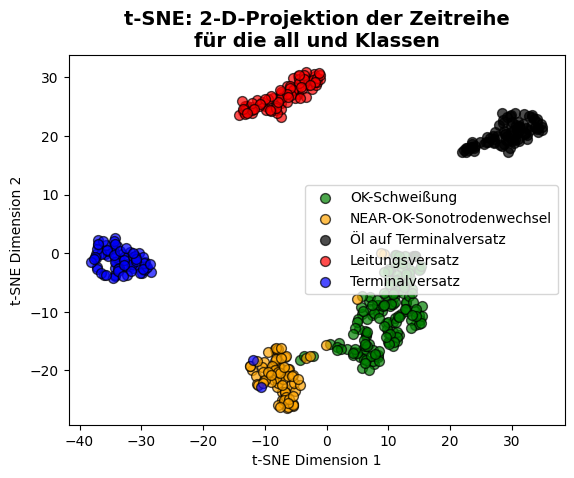

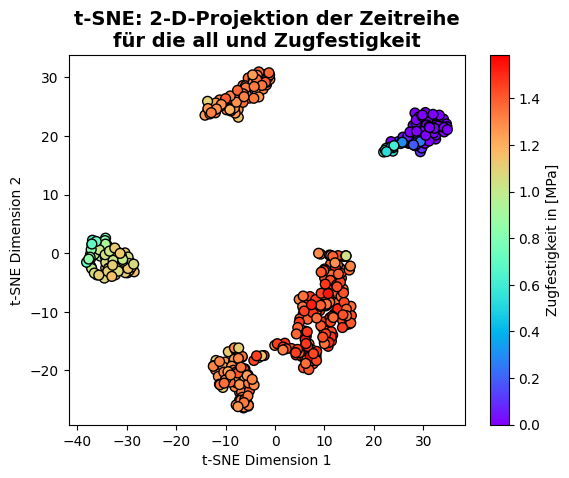

In [231]:
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'all', 'Klassen')
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'all', 'Zugfestigkeit')

<b><font color='lightgreen'><h3> SVC - Support Vector Classification (Hyperparametersuche - Random Search)

In [232]:
params = {
    'C': np.logspace(0, 4),       
    'gamma': np.logspace(-5, 1), 
}
random_search_svc = model_selection.RandomizedSearchCV(
    svm.SVC(),
    params,
    n_iter=100,
    n_jobs=-1
)
_ = random_search_svc.fit(X_train_scaled, label_train)
modelSVC_best = random_search_svc.best_estimator_

# Vorhersage
pred_train = modelSVC_best.predict(X_train_scaled)
pred_test  = modelSVC_best.predict(X_test_scaled)

modelSVC_best

SVC(C=719.6856730011514, gamma=0.19306977288832497)

<b><font color='lightgreen'> Modellbewertung</b>

In [233]:
helper.get_metric_table_class(label_train, pred_train, label_test, pred_test)

                        precision    recall  f1-score   support

                    ok      1.000     1.000     1.000        43
   near_ok_sonowechsel      1.000     1.000     1.000        19
            fehler_oel      1.000     1.000     1.000        17
fehler_leitungsversatz      1.000     1.000     1.000        17
  fehler_terminversatz      1.000     1.000     1.000        24

              accuracy                          1.000       120
             macro avg      1.000     1.000     1.000       120
          weighted avg      1.000     1.000     1.000       120



,Train,Test
Metric,,
Accuracy,0.998,1.000
Precision,0.998,1.000
Recall,0.998,1.000
F1-score,0.998,1.000


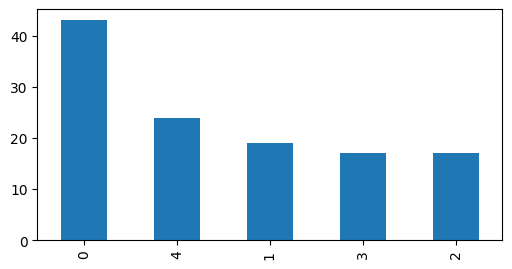

In [234]:
plt.figure(figsize=(6, 5))
pd.Series(pred_test).value_counts().plot.bar(figsize=(6, 3))
plt.plot(cmap="Blues")
plt.show()

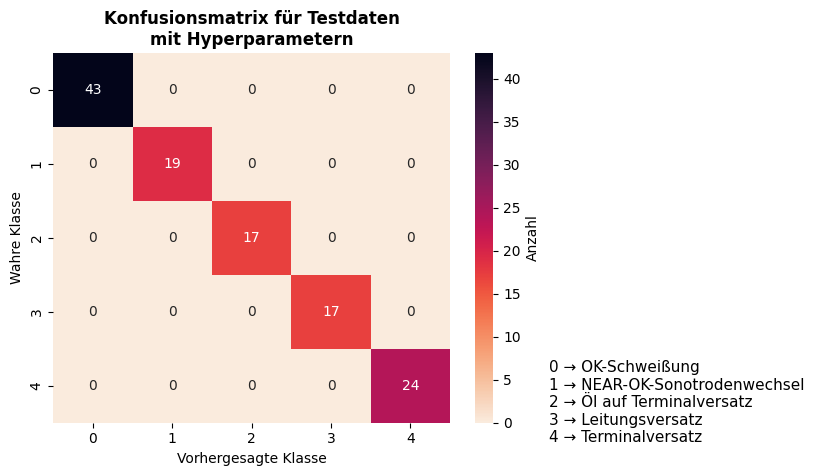

In [235]:
helper.plot_confusion(label_test, pred_test, 'Testdaten\nmit Hyperparametern')

In [236]:
# ❌ joblib.dump({'scaler': std_scaler, 'svr_stat': modelSVC_best}, 'GUI/Maschine1/svc_stat.joblib')
joblib.dump(modelSVC_best, 'GUI/Maschine1/svc_stat.joblib')

['GUI/Maschine1/svc_stat.joblib']

<b><font color='lightgreen'><h3> SVR - Support Vector Regression (Hyperparameter Random Search) </b>

In [237]:
params = {
    'C':       np.logspace( 0, 3), 
    'epsilon': np.logspace(-6, 1), 
    'gamma':   np.logspace(-6, 1), 
    'kernel': ['rbf'],#, 'linear'],
}
estimator_regr = model_selection.RandomizedSearchCV(
    svm.SVR(),
    params,
    n_iter=50,
    n_jobs=-1
)
estimator_regr.fit(X_train_scaled, festigkeit_train)
best_estimator = estimator_regr.best_estimator_

# Vorhersage
y_pred_train = best_estimator.predict(X_train_scaled)
y_pred_test  = best_estimator.predict(X_test_scaled)

best_estimator

SVR(C=44.98432668969446, epsilon=2.6826957952797274e-06,
    gamma=0.05179474679231213)

<b><font color='lightgreen'> Modellbewertung</b>

In [238]:
helper.get_metric_table_regr(festigkeit_train, y_pred_train, festigkeit_test, y_pred_test, SCALE)

,Train,Test
Metric,,
MSE,10958.70,10718.53
RMSE,104.68,103.53
MAE,72.04,73.36
R²,0.99,0.99


<b><font color='lightgreen'> Vorhersage Trainings- & Testdaten

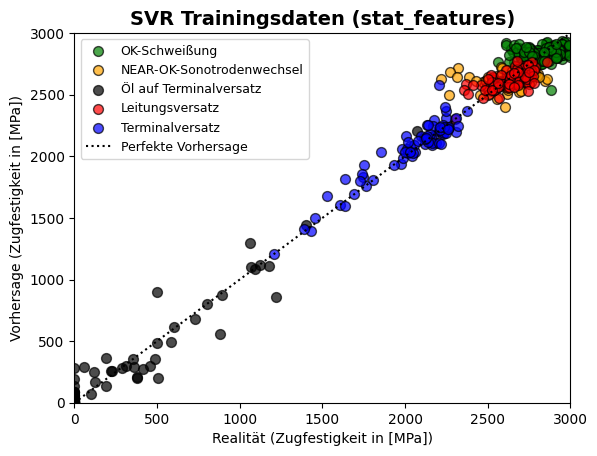

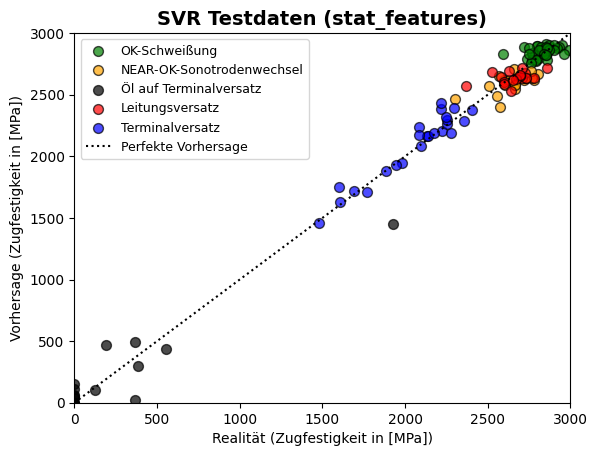

In [239]:
helper.plot_pred(y_pred_train, festigkeit_train, label_train, 'SVR Trainingsdaten (stat_features)', 'mit Linie', SCALE)
helper.plot_pred(y_pred_test,  festigkeit_test,  label_test,  'SVR Testdaten (stat_features)',      'mit Linie', SCALE)

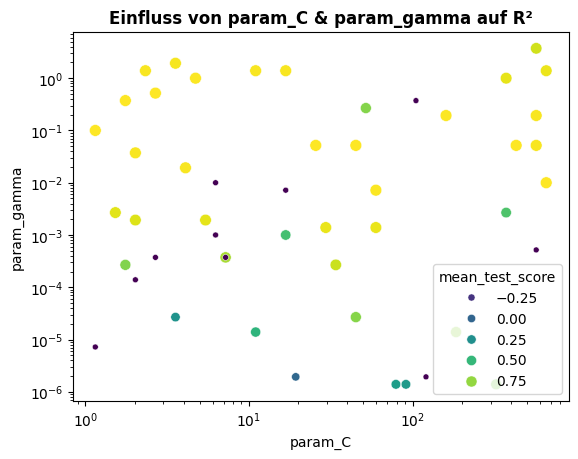

In [240]:
helper.plot_params(estimator_regr, "param_C", "param_gamma")

In [241]:
joblib.dump(best_estimator, 'GUI/Maschine1/svr_stat.joblib')

['GUI/Maschine1/svr_stat.joblib']